In [19]:
import copy

import pandas as pd
import numpy as np
import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, f1_score
from utility.text_normalizer import *
from utility.get_twitter import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import joblib

# Load Support Functions

In [2]:
def get_log_loss(model, y_true, X):
    y_hat = model.predict_proba(X)[:, 1]
    return log_loss(y_true, y_hat)

def print_scores(model, y_true, X_val):
    y_pred = model.predict(X_val)
    print(classification_report(y_true, y_pred, target_names=['irrelevant', 'relevant']))
    sns.heatmap(confusion_matrix(y_true, y_pred).T, square=True, annot=True, fmt='d')

# Load data

In [3]:
train = pd.read_parquet('data/selftrain_data.gzip')
test = pd.read_parquet('data/test_initial.gzip')

In [9]:
train.shape, test.shape

((44044, 15), (660, 3))

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44044 entries, 706 to 17187
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   tweet_id    44044 non-null  object        
 1   text        44044 non-null  object        
 2   tag         44044 non-null  float64       
 3   grid_id     42724 non-null  float64       
 4   created_at  42724 non-null  datetime64[ns]
 5   author_id   42724 non-null  object        
 6   place_id    39752 non-null  object        
 7   lat         23381 non-null  float64       
 8   long        23381 non-null  float64       
 9   full_name   39748 non-null  object        
 10  name        39748 non-null  object        
 11  place_type  39748 non-null  object        
 12  id          42724 non-null  float64       
 13  county      42724 non-null  object        
 14  tag_proba   42724 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(8)
memory usage: 5.4+ MB


In [13]:
train.head()

,tweet_id,text,tag,grid_id,created_at,author_id,place_id,lat,long,full_name,name,place_type,id,county,tag_proba
706,363824209840992256,"I'm at Coyote Cantina (Redondo Beach, CA) http...",0.0,NaN,NaT,None,None,NaN,NaN,None,None,None,NaN,None,NaN
360,699298531815718912,@CoyoteWags coyotes are so fabulous! -yips eve...,1.0,NaN,NaT,None,None,NaN,NaN,None,None,None,NaN,None,NaN
50,155138791856807937,Yeewwwwwwwwww (@ STAPLES Center for Phoenix Co...,0.0,NaN,NaT,None,None,NaN,NaN,None,None,None,NaN,None,NaN
299,850790083602939904,BASE | @SonomaSeawolves lead 7-0 over the Coyo...,0.0,NaN,NaT,None,None,NaN,NaN,None,None,None,NaN,None,NaN
692,442753097925132288,Us coyotes are getting wild today!!! I love my...,0.0,NaN,NaT,None,None,NaN,NaN,None,None,None,NaN,None,NaN


In [16]:
train.shape[0] - train['tag_proba'].notnull().sum()

1320

In [5]:
# train = train[(train['ml_tag_proba'] >= 0.90) | (train['ml_tag_proba'] <= 0.02)]

In [6]:
# train.to_parquet('data/proxy_train_1_iter.gzip', index=None)

# Load Model

In [31]:
m_proxy_nb = joblib.load('../../../models/baseline_nb.pkl')
m_baseline_nb = copy.deepcopy(m_proxy_nb)

In [39]:
m_baseline = joblib.load('../../../models/baseline_cvsvm.pkl')
m_proxy = copy.deepcopy(m_baseline)

In [40]:
m_proxy.fit(train['text'], train['tag'])

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Pipeline(steps=[('cv',
                 CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>,
                                 stop_words='english')),
                ('svc', SVC(C=3, kernel='sigmoid', probability=True))])

In [32]:
m_proxy_nb.fit(train['text'], train['tag'])

Pipeline(steps=[('cv',
                 CountVectorizer(min_df=4, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>)),
                ('nb', MultinomialNB(alpha=6))])

              precision    recall  f1-score   support

  irrelevant       0.96      0.82      0.88       452
    relevant       0.70      0.92      0.80       208

    accuracy                           0.85       660
   macro avg       0.83      0.87      0.84       660
weighted avg       0.88      0.85      0.86       660

Log Loss: 1.37621


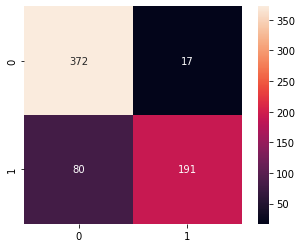

In [41]:
print_scores(m_proxy, test['tag'], test['text'])

/Users/Isaacbolo/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


              precision    recall  f1-score   support

  irrelevant       0.90      0.90      0.90       452
    relevant       0.79      0.79      0.79       208

    accuracy                           0.87       660
   macro avg       0.85      0.85      0.85       660
weighted avg       0.87      0.87      0.87       660

Log Loss: 0.33273


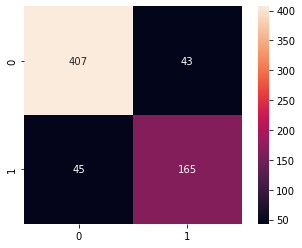

In [42]:
print_scores(m_baseline, test['tag'], test['text'])

              precision    recall  f1-score   support

  irrelevant       0.97      0.81      0.88       452
    relevant       0.70      0.95      0.80       208

    accuracy                           0.85       660
   macro avg       0.83      0.88      0.84       660
weighted avg       0.89      0.85      0.86       660

Log Loss: 1.19949


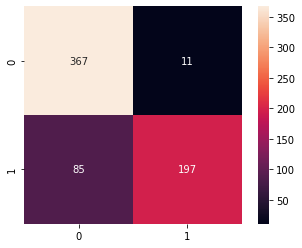

In [35]:
print_scores(m_proxy_nb, test['tag'], test['text'])

              precision    recall  f1-score   support

  irrelevant       0.93      0.87      0.90       452
    relevant       0.75      0.85      0.80       208

    accuracy                           0.87       660
   macro avg       0.84      0.86      0.85       660
weighted avg       0.87      0.87      0.87       660

Log Loss: 0.42120


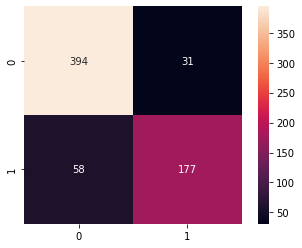

In [36]:
print_scores(m_baseline_nb, test['tag'], test['text'])

It's best not to use log-loss as a metric because SVC's probabilities are not always consistent with its argmax predictions. For example, for an observation, probability could be > .5 and predict 0, where 0.5 is the hard prediction cut off.

In [43]:
# Save model
# joblib.dump(m_proxy, '../../../models/SVC_proxlabel.pkl')
# joblib.dump(m_proxy_nb, '../../../models/NB_proxylabel.pkl')

['../../../models/NB_proxylabel.pkl']

In [47]:
f1_scores = []
for model in [m_proxy_nb, m_proxy, m_baseline, m_baseline_nb]:
    f1_scores.append((model,f1_score(test['tag'], model.predict(test['text']))))

In [49]:
f1_scores

[(Pipeline(steps=[('cv',
                   CountVectorizer(min_df=4, ngram_range=(1, 2),
                                   preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>)),
                  ('nb', MultinomialNB(alpha=6))]),
  0.8040816326530613),
 (Pipeline(steps=[('cv',
                   CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                   preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>,
                                   stop_words='english')),
                  ('svc', SVC(C=3, kernel='sigmoid', probability=True))]),
  0.7974947807933193),
 (Pipeline(steps=[('cv',
                   CountVectorizer(lowercase=False, ngram_range=(1, 2),
                                   preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>,
                                   stop_words='english')),
                  ('svc', SVC(C=3, kernel='sigmoid', probability=True))]),
  0.7894736842105263),
 (Pipeline(steps=[('cv',
         

In [52]:
best_model = max(f1_scores, key=lambda x: x[1])[0]
best_model

Pipeline(steps=[('cv',
                 CountVectorizer(min_df=4, ngram_range=(1, 2),
                                 preprocessor=<function tweet_preprocessor at 0x7f8a3c740af0>)),
                ('nb', MultinomialNB(alpha=6))])

## Check out the predictions

In [53]:
test['ml_pred'] = best_model.predict(test['text'])

In [28]:
test

,tweet_id,text,tag,ml_pred,ml_pred2
45,548718940562530304,Fremont Police Kill Coyote After It Attacks Re...,1.0,0.0,0.0
917,798749289421733889,Tf just saw a coyote on campus,1.0,1.0,1.0
780,834212891553263616,Most discussed topic in San Jose right now: Co...,0.0,0.0,0.0
679,25505738555,...volunteering at National Public Lands Day! ...,0.0,0.0,0.0
241,560113978546741248,'They're chewing the roots of the vine' #Coyot...,0.0,0.0,0.0
...,...,...,...,...,...
172,1038277288989660032,9 min left in the game and the Coyotes down 42...,0.0,0.0,0.0
760,1460473121463410693,It will send a message to the Coyotes and immi...,0.0,0.0,0.0
323,1071163306499563648,"Coyote Magic! \nYou can’t see them all, but th...",1.0,1.0,1.0
0,1297680994309419008,City coyote out for an afternoon stroll in Bue...,1.0,1.0,1.0
